1. 전처리를 수행한 파일을 불러온 후 특성 변수와 결과로 나눈다. 
- 특성 변수 X (성별, 흡연여부, 나이, BMI, 자녀수)
- 결과 y (보험료)

In [1]:
import pandas as pd

df = pd.read_csv('insuranceS.csv')
df.head()

,Unnamed: 0,남성,여성,흡연자,비흡연자,나이,BMI,자녀수,보험료
0,0,1,0,0,1,-1.438764,-0.453320,-0.908614,16884.92400
1,1,0,1,1,0,-1.509965,0.509621,-0.078767,1725.55230
2,2,0,1,1,0,-0.797954,0.383307,1.580926,4449.46200
3,3,0,1,1,0,-0.441948,-1.305531,-0.908614,21984.47061
4,4,0,1,1,0,-0.513149,-0.292556,-0.908614,3866.85520


In [2]:
X = df.drop('보험료', axis=1)   # X = df.iloc[:, :-1], X = df[df.columns[:-1]]
print(X.shape)
X.head()

(1338, 8)


,Unnamed: 0,남성,여성,흡연자,비흡연자,나이,BMI,자녀수
0,0,1,0,0,1,-1.438764,-0.453320,-0.908614
1,1,0,1,1,0,-1.509965,0.509621,-0.078767
2,2,0,1,1,0,-0.797954,0.383307,1.580926
3,3,0,1,1,0,-0.441948,-1.305531,-0.908614
4,4,0,1,1,0,-0.513149,-0.292556,-0.908614


In [3]:
y = df[['보험료']]    # DataFrame으로 반환 -> [] 하나만 사용한 경우는 Series로 반환
print(y.shape)
y.head()

(1338, 1)


,보험료
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520


2. Train - Test 데이터셋 나누기
- train_test_split()를 사용하여 데이터셋 구분하여 각각 csv 파일로 저장 

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)    # random_state는 seed와 같은 역할
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

(1003, 8) (335, 8) (1003, 1) (335, 1)


3. 모델 구성

In [22]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

def build_model():
    model = Sequential()                                                      # Sequential: 순차적으로 레이어를 쌓아가는 모델
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))  # input_shape: 입력 데이터의 형태  
    model.add(Dense(64, activation='relu'))                                   # Dense: 완전연결층
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))                                                       # 출력층
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])           # mse: 평균제곱오차, mae: 평균절대오차
    return model

In [18]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________


- K=4인 kfold 교차검증 시행하여 train data, validatin data 나누어 학습
- epochs = 500

In [23]:
k = 4

num_val_samples = len(X_train) // k     
num_epochs = 500
all_mae_histories = []                    # 모든 폴드의 검증 점수를 로그에 저장     

for i in range(k):
  print('처리중인 폴드 #', i)

  # 검증 데이터 준비: k번째 분할
  X_val = X_train[i * num_val_samples: (i + 1) * num_val_samples]    # 검증 데이터: k번째 분할
  y_val = y_train[i * num_val_samples: (i + 1) * num_val_samples]    

  # 훈련 데이터 준비: 다른 분할 전체
  partial_X_train = np.concatenate([X_train[:i * num_val_samples], X_train[(i + 1) * num_val_samples:]], axis=0)    # 훈련 데이터: 다른 분할 전체
  partial_y_train = np.concatenate([y_train[:i * num_val_samples], y_train[(i + 1) * num_val_samples:]], axis=0)    

  model = build_model()   # 케라스 모델 구성(컴파일 포함)
  history = model.fit(partial_X_train, partial_y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size=1, verbose=1)    # 모델 훈련(verbose=1: 훈련 과정 출력)

  mae_history = history.history['mae']    # 검증 데이터에 대한 MAE 기록
  all_mae_histories.append(mae_history)


처리중인 폴드 # 0
Epoch 1/500
753/753 [==============================] - 1s 1ms/step - loss: 201949776.0000 - mae: 10001.6895 - val_loss: 197067856.0000 - val_mae: 9678.4268
Epoch 2/500
753/753 [==============================] - 1s 1ms/step - loss: 184344384.0000 - mae: 9621.4863 - val_loss: 193957520.0000 - val_mae: 9936.3633
Epoch 3/500
753/753 [==============================] - 1s 1ms/step - loss: 182614624.0000 - mae: 9606.7061 - val_loss: 199493904.0000 - val_mae: 10663.0049
Epoch 4/500
753/753 [==============================] - 1s 1ms/step - loss: 183782096.0000 - mae: 9730.1299 - val_loss: 193007744.0000 - val_mae: 9874.6514
Epoch 5/500
753/753 [==============================] - 1s 1ms/step - loss: 182222016.0000 - mae: 9557.0146 - val_loss: 198540608.0000 - val_mae: 10652.9170
Epoch 6/500
753/753 [==============================] - 1s 1ms/step - loss: 182442016.0000 - mae: 9683.7529 - val_loss: 191711424.0000 - val_mae: 9935.8350
Epoch 7/500
753/753 [==============================] - 

4. 모델 학습

In [25]:
# 폴드마다 계산된 mae 점수의 평균을 계산 
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]    # 500개의 epoch에 대해 평균 MAE 점수 계산
len(average_mae_history)

500

5. 그래프로 그리기

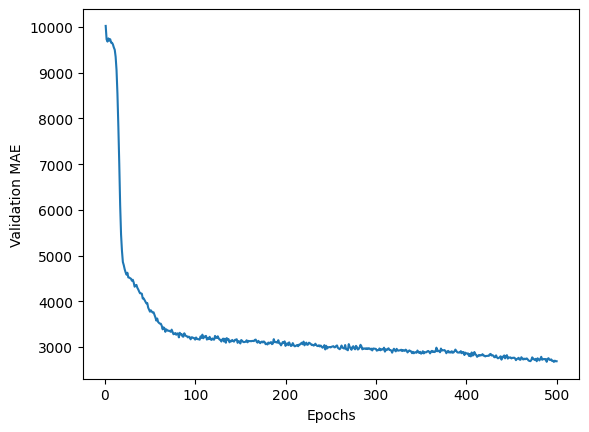

In [26]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)    # 그래프 그리기
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Validation MAE의  폭이  너무  크기  때문에 epoch 10 이후의  MAE를  제대로  볼  수  없음 => 그래프  수정  필요!!

In [30]:
def smooth_curve(points, factor=0.9):    # 지수 이동 평균(exponential moving average)을 구하기 위한 함수
  smoothed_points = []
  for point in points:
    if smoothed_points:                 # smoothed_points가 비어있지 않으면
      previous = smoothed_points[-1]    # 지수 이동 평균을 구하기 위해 이전 데이터 포인트에 factor를 곱하고 현재 포인트에 (1 - factor)를 곱함
      smoothed_points.append(previous * factor + point * (1 - factor))    # 지수 이동 평균 계산
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])    # 처음 10개의 데이터 포인트를 제외한 지수 이동 평균

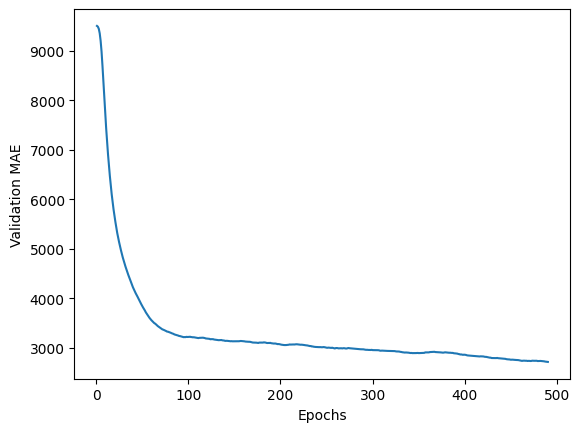

In [31]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)    # 그래프 그리기
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

6. 모델 성능 평가

In [33]:
# 최종 모델 훈련
model = build_model()    # 새롭게 컴파일된 모델을 얻음
model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=0)    # 전체 데이터로 훈련시킴
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)      # 테스트 데이터로 모델 평가
print(test_mae_score, test_mse_score)

11/11 [==============================] - 0s 1ms/step - loss: 23569154.0000 - mae: 2428.3364
2428.33642578125 23569154.0


In [34]:
# X를 넣어서 예측값 y를 얻음
print('실제 : ', y[543:544])
print('예측 : ', model.predict(X[543:544]))

실제 :               보험료
543  63770.42801
1/1 [==============================] - 0s 72ms/step
예측 :  [[56998.82]]


In [35]:
print('실제 : ', y[940:941])
print('예측 : ', model.predict(X[940:941]))

실제 :             보험료
940  1121.8739
1/1 [==============================] - 0s 17ms/step
예측 :  [[3262.5828]]


‐ 사이킷런에서  제공하는  KFold()함수를  사용하여  K=10인  Kfold를  시행한  경우

In [36]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=50)
cvscores = []

X1 = X.to_numpy()
y1 = y.to_numpy()

i = 1

for train, test in kfold.split(X1, y1):
  model = build_model()                                                     
  model.fit(X1[train], y1[train], epochs=150, batch_size=10, verbose=0)     # 모델 훈련
  scores = model.evaluate(X1[test], y1[test], verbose=0)                    # 모델 평가
  print("%d: %s: %.2f" % (i, model.metrics_names[1], scores[1]))
  cvscores.append(scores[1])                                                # 모델의 정확도를 cvscores에 저장
  i += 1

print("%.2f (+/= %.2f)" % (np.mean(cvscores), np.std(cvscores)))            # 평균과 표준편차 출력

1: mae: 3069.73
2: mae: 2452.50
3: mae: 2994.20
4: mae: 5524.53
5: mae: 7019.58
6: mae: 3834.94
7: mae: 3406.46
8: mae: 2747.88
9: mae: 3698.55
10: mae: 3621.88
3837.03 (+/= 1327.76)


In [37]:
print('실제 : ', y[543:544])
print('예측 : ', model.predict(X[543:544]))

실제 :               보험료
543  63770.42801
1/1 [==============================] - 0s 51ms/step
예측 :  [[62097.258]]


In [38]:
print('실제 : ', y[940:941])
print('예측 : ', model.predict(X[940:941]))

실제 :             보험료
940  1121.8739
1/1 [==============================] - 0s 17ms/step
예측 :  [[3063.6584]]


7. 모델 성능과 결과

In [39]:
charges_mean = y.mean() / 10
print(charges_mean)

보험료    1327.042227
dtype: float64
